## Imports

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
K.clear_session()

## Functions

In [2]:
# extract prefix to group by participant insted of trip
def extract_prefix(filename):
    # split filename on '_' 
    return re.split(r'_', filename)[0]

# create sequences of consecutive intrevales 
def create_sequences(data, labels, filenames, window_size):
    # vars to store the sequences and the respective labels
    sequences = []
    sequence_labels = []
    
    # get the file name to filter by participant
    current_prefix = extract_prefix(filenames[0])
    current_sequence = []
    current_labels = []
    
    # loop all intrevals
    for i in range(len(data)):
        # get current filename
        prefix = extract_prefix(filenames[i])
        
        # if the intreval belongs to diferent participant reset the sequences and vars
        if prefix != current_prefix:
            current_prefix = prefix
            current_sequence = [] 
            current_labels = []

        # add the intrevlal and the label to the current sequence
        current_sequence.append(data[i])
        current_labels.append(labels[i])
        
        # check if the sequence reach the max size and if so, store the sequence and the lable
        if len(current_sequence) == window_size:
            sequences.append(current_sequence.copy()) 
            sequence_labels.append(current_labels[-1]) 
            current_sequence.pop(0)

    return np.array(sequences), np.array(sequence_labels)


## Data Pre-Processing

In [3]:
# get data
file_path_1 = '../pre_process_2/datasets_v2/supervised_1_min.csv'
file_path_2 = '../pre_process_2/datasets_v2/supervised_2_min.csv'
file_path_3 = '../pre_process_2/datasets_v2/supervised_3_min.csv'
file_path_5 = '../pre_process_2/datasets_v2/supervised_5_min.csv'
file_path_8 = '../pre_process_2/datasets_v2/supervised_8_min.csv'

df_1_min = pd.read_csv(file_path_1, delimiter=',')
df_2_min = pd.read_csv(file_path_2, delimiter=',')
df_3_min = pd.read_csv(file_path_3, delimiter=',')
df_5_min = pd.read_csv(file_path_5, delimiter=',')
df_8_min = pd.read_csv(file_path_8, delimiter=',')


# filenames with the "pvt recording"
filenames_to_remove = [
    "fp01_2.edf", "fp01_4.edf", "fp02_1.edf", "fp02_2.edf", "fp02_4.edf",
    "fp03_1.edf", "fp03_2.edf", "fp04_1.edf", "fp05_1.edf", "fp06_1.edf",
    "fp07_1.edf", "fp08_1.edf", "fp09_1.edf", "fp10_1.edf", "fp11_1.edf",
    "fp12_1.edf", "fp13_1.edf", "fp14_1.edf", "fp14_3.edf", "fp15_1.edf",
    "fp16_1.edf", "fp17_1.edf", "fp17_2.edf", "fp17_4.edf", "fp18_1.edf",
    "fp18_2.edf", "fp19_1.edf", "fp19_3.edf", "fp19_4.edf", "fp20_1.edf", 
    "fp20_3.edf"
]

# remove the unwanted instances from the dfs
df_1_min = df_1_min[~df_1_min['Filename'].isin(filenames_to_remove)]
df_2_min = df_2_min[~df_2_min['Filename'].isin(filenames_to_remove)]
df_3_min = df_3_min[~df_3_min['Filename'].isin(filenames_to_remove)]
df_5_min = df_5_min[~df_5_min['Filename'].isin(filenames_to_remove)]
df_8_min = df_8_min[~df_8_min['Filename'].isin(filenames_to_remove)]

# remove columns with null values
df_1_min = df_1_min[(df_1_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_2_min = df_2_min[(df_2_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_3_min = df_3_min[(df_3_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_5_min = df_5_min[(df_5_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]
df_8_min = df_8_min[(df_8_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]

# remove missing values
df_1_min = df_1_min.dropna()
df_2_min = df_2_min.dropna()
df_3_min = df_3_min.dropna()
df_5_min = df_5_min.dropna()
df_8_min = df_8_min.dropna()

# get wanted features for training data
df_features_1_min = df_1_min[(df_1_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_2_min = df_2_min[(df_2_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_3_min = df_3_min[(df_3_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_5_min = df_5_min[(df_5_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]
df_features_8_min = df_8_min[(df_8_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]

# final wanted features
features_1_min = df_features_1_min.columns.to_list()
features_2_min = df_features_2_min.columns.to_list()
features_3_min = df_features_3_min.columns.to_list()
features_5_min = df_features_5_min.columns.to_list()
features_8_min = df_features_8_min.columns.to_list()

### Normalization

In [4]:
# Normalize data
scaler = StandardScaler()
X_scaled_1_min = scaler.fit_transform(df_1_min[features_1_min].values)
X_scaled_2_min = scaler.fit_transform(df_2_min[features_2_min].values)
X_scaled_3_min = scaler.fit_transform(df_3_min[features_3_min].values)
X_scaled_5_min = scaler.fit_transform(df_5_min[features_5_min].values)
X_scaled_8_min = scaler.fit_transform(df_8_min[features_8_min].values)

### Descretrization

In [5]:
# descretize the value of KSS
labels_1_min = (df_1_min['kss_answer'] > 6).astype(int)
labels_2_min = (df_2_min['kss_answer'] > 6).astype(int)
labels_3_min = (df_3_min['kss_answer'] > 6).astype(int)
labels_5_min = (df_5_min['kss_answer'] > 6).astype(int)
labels_8_min = (df_8_min['kss_answer'] > 6).astype(int)

### Prepare data to train the model

In [10]:
# get all filenames
filenames_1_min = df_1_min['Filename'].values
filenames_2_min = df_2_min['Filename'].values
filenames_3_min = df_3_min['Filename'].values
filenames_5_min = df_5_min['Filename'].values
filenames_8_min = df_8_min['Filename'].values

# window sizes 
window_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# results for each window size
window_size_results = []

### Create sequences and train Models

In [11]:
# loop window sizes
for window_size in window_sizes:
    print(f"\nTraining models with window size: {window_size}")
    
    # create sequences for each dataset based on the window size
    X_sequences_1_min, y_sequences_1_min = create_sequences(X_scaled_1_min, labels_1_min.values, filenames_1_min, window_size)
    X_sequences_2_min, y_sequences_2_min = create_sequences(X_scaled_2_min, labels_2_min.values, filenames_2_min, window_size)
    X_sequences_3_min, y_sequences_3_min = create_sequences(X_scaled_3_min, labels_3_min.values, filenames_3_min, window_size)
    X_sequences_5_min, y_sequences_5_min = create_sequences(X_scaled_5_min, labels_5_min.values, filenames_5_min, window_size)
    X_sequences_8_min, y_sequences_8_min = create_sequences(X_scaled_8_min, labels_8_min.values, filenames_8_min, window_size)

    # split into training and testing 
    X_train_1_min, X_test_1_min, y_train_1_min, y_test_1_min = train_test_split(X_sequences_1_min, y_sequences_1_min, test_size=0.20, random_state=42)
    X_train_2_min, X_test_2_min, y_train_2_min, y_test_2_min = train_test_split(X_sequences_2_min, y_sequences_2_min, test_size=0.20, random_state=42)
    X_train_3_min, X_test_3_min, y_train_3_min, y_test_3_min = train_test_split(X_sequences_3_min, y_sequences_3_min, test_size=0.20, random_state=42)
    X_train_5_min, X_test_5_min, y_train_5_min, y_test_5_min = train_test_split(X_sequences_5_min, y_sequences_5_min, test_size=0.20, random_state=42)
    X_train_8_min, X_test_8_min, y_train_8_min, y_test_8_min = train_test_split(X_sequences_8_min, y_sequences_8_min, test_size=0.20, random_state=42)

    # models 
    models = []
    for X_train, y_train in zip([X_train_1_min, X_train_2_min, X_train_3_min, X_train_5_min, X_train_8_min],
                                [y_train_1_min, y_train_2_min, y_train_3_min, y_train_5_min, y_train_8_min]):
        model = Sequential([
            LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        models.append(model)

    # train models
    histories = []
    for model, X_train, y_train in zip(models, [X_train_1_min, X_train_2_min, X_train_3_min, X_train_5_min, X_train_8_min],
                                       [y_train_1_min, y_train_2_min, y_train_3_min, y_train_5_min, y_train_8_min]):
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
        histories.append(history)

    # evaluate models and store metrics
    for model, X_test, y_test, history, interval in zip(models, [X_test_1_min, X_test_2_min, X_test_3_min, X_test_5_min, X_test_8_min],
                                                        [y_test_1_min, y_test_2_min, y_test_3_min, y_test_5_min, y_test_8_min],
                                                        histories, ['1 min', '2 min', '3 min', '5 min', '8 min']):
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)

        # compute metrics
        accuracy = accuracy_score(y_test, y_pred_binary)
        precision = precision_score(y_test, y_pred_binary)
        recall = recall_score(y_test, y_pred_binary)
        f1 = f1_score(y_test, y_pred_binary)

        # ave metrics
        window_size_results.append({
            'window_size': window_size,
            'interval': interval,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'train_accuracy': history.history['accuracy'][-1],
            'val_accuracy': history.history['val_accuracy'][-1]
        })


Training models with window size: 1
Epoch 1/50


c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5513 - loss: 0.6867 - val_accuracy: 0.6106 - val_loss: 0.6627
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.6064 - loss: 0.6608 - val_accuracy: 0.6293 - val_loss: 0.6398
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.6197 - loss: 0.6451 - val_accuracy: 0.6451 - val_loss: 0.6285
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.6319 - loss: 0.6321 - val_accuracy: 0.6566 - val_loss: 0.6203
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.6410 - loss: 0.6323 - val_accuracy: 0.6595 - val_loss: 0.6140
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6465 - loss: 0.6200 - val_accuracy: 0.6652 - val_loss: 0.6066
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6552 - loss: 0.6166 - val_accuracy: 0.6695 - val_loss: 0.6021
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.6695 - loss: 0.6088 - val_accuracy: 0.6839 - val_lo

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5748 - loss: 0.6771 - val_accuracy: 0.6522 - val_loss: 0.6395
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6219 - loss: 0.6396 - val_accuracy: 0.6710 - val_loss: 0.6151
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6431 - loss: 0.6166 - val_accuracy: 0.6926 - val_loss: 0.6003
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6747 - loss: 0.6041 - val_accuracy: 0.7056 - val_loss: 0.5869
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.6840 - loss: 0.5920 - val_accuracy: 0.7114 - val_loss: 0.5738
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.6821 - loss: 0.5752 - val_accuracy: 0.7201 - val_loss: 0.5648
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6926 - loss: 0.5681 - val_accuracy: 0.7172 - val_loss: 0.5577
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7001 - loss: 0.5581 - val_accuracy: 0.7345 - val_lo

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5741 - loss: 0.6812 - val_accuracy: 0.6493 - val_loss: 0.6227
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6411 - loss: 0.6287 - val_accuracy: 0.6696 - val_loss: 0.6077
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6644 - loss: 0.6031 - val_accuracy: 0.6826 - val_loss: 0.5985
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6893 - loss: 0.5969 - val_accuracy: 0.6884 - val_loss: 0.5856
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6955 - loss: 0.5777 - val_accuracy: 0.7058 - val_loss: 0.5718
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7112 - loss: 0.5639 - val_accuracy: 0.7203 - val_loss: 0.5599
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7057 - loss: 0.5591 - val_accuracy: 0.7246 - val_loss: 0.5505
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7298 - loss: 0.5392 - val_accuracy: 0.7304 - val_loss: 0.5423
Epo

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5731 - loss: 0.6789 - val_accuracy: 0.6943 - val_loss: 0.6084
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6885 - loss: 0.6048 - val_accuracy: 0.7031 - val_loss: 0.5751
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.7152 - loss: 0.5702 - val_accuracy: 0.7060 - val_loss: 0.5503
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7231 - loss: 0.5448 - val_accuracy: 0.7220 - val_loss: 0.5347
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7419 - loss: 0.5265 - val_accuracy: 0.7191 - val_loss: 0.5207
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.7416 - loss: 0.5111 - val_accuracy: 0.7176 - val_loss: 0.5126
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7622 - loss: 0.4975 - val_accuracy: 0.7365 - val_loss: 0.5024
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7744 - loss: 0.4804 - val_accuracy: 0.7496 - val_loss: 0.49

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6118 - loss: 0.6649 - val_accuracy: 0.6911 - val_loss: 0.5959
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6714 - loss: 0.5893 - val_accuracy: 0.7086 - val_loss: 0.5602
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7084 - loss: 0.5617 - val_accuracy: 0.7423 - val_loss: 0.5320
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7140 - loss: 0.5487 - val_accuracy: 0.7584 - val_loss: 0.5048
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.7352 - loss: 0.5259 - val_accuracy: 0.7599 - val_loss: 0.4895
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7318 - loss: 0.5123 - val_accuracy: 0.7745 - val_loss: 0.4713
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7551 - loss: 0.4973 - val_accuracy: 0.7701 - val_loss: 0.4619
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7561 - loss: 0.4790 - val_accuracy: 0.7745 - val_loss: 0.4550
E

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5848 - loss: 0.6678 - val_accuracy: 0.6691 - val_loss: 0.5994
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6749 - loss: 0.6051 - val_accuracy: 0.7132 - val_loss: 0.5529
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.7017 - loss: 0.5710 - val_accuracy: 0.7412 - val_loss: 0.5172
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7402 - loss: 0.5299 - val_accuracy: 0.7515 - val_loss: 0.5065
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7541 - loss: 0.5033 - val_accuracy: 0.7603 - val_loss: 0.4942
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7578 - loss: 0.4869 - val_accuracy: 0.7809 - val_loss: 0.4723
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7730 - loss: 0.4714 - val_accuracy: 0.7868 - val_loss: 0.4695
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7752 - loss: 0.4575 - val_accuracy: 0.7868 - val_loss: 0.4530

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5980 - loss: 0.6572 - val_accuracy: 0.7001 - val_loss: 0.5853
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6940 - loss: 0.5929 - val_accuracy: 0.7194 - val_loss: 0.5512
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7258 - loss: 0.5443 - val_accuracy: 0.7371 - val_loss: 0.5121
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7305 - loss: 0.5098 - val_accuracy: 0.7430 - val_loss: 0.4798
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7482 - loss: 0.4912 - val_accuracy: 0.7415 - val_loss: 0.4596
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7613 - loss: 0.4656 - val_accuracy: 0.7489 - val_loss: 0.4462
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7703 - loss: 0.4490 - val_accuracy: 0.7740 - val_loss: 0.4277
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7832 - loss: 0.4347 - val_accuracy: 0.7903 - val_loss: 0.4087
Epo

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6261 - loss: 0.6466 - val_accuracy: 0.6751 - val_loss: 0.5939
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7215 - loss: 0.5669 - val_accuracy: 0.7077 - val_loss: 0.5480
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7334 - loss: 0.5306 - val_accuracy: 0.7507 - val_loss: 0.5004
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.4924 - val_accuracy: 0.7760 - val_loss: 0.4746
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7763 - loss: 0.4762 - val_accuracy: 0.8027 - val_loss: 0.4459
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7983 - loss: 0.4338 - val_accuracy: 0.8042 - val_loss: 0.4249
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8067 - loss: 0.4112 - val_accuracy: 0.8131 - val_loss: 0.4023
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8123 - loss: 0.3933 - val_accuracy: 0.8294 - val_loss: 0.3880
Epo

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5988 - loss: 0.6534 - val_accuracy: 0.6662 - val_loss: 0.6091
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6942 - loss: 0.5833 - val_accuracy: 0.7109 - val_loss: 0.5732
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.5390 - val_accuracy: 0.7362 - val_loss: 0.5295
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7628 - loss: 0.4952 - val_accuracy: 0.7437 - val_loss: 0.5059
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.4730 - val_accuracy: 0.7586 - val_loss: 0.4858
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7799 - loss: 0.4446 - val_accuracy: 0.7705 - val_loss: 0.4734
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.4232 - val_accuracy: 0.7973 - val_loss: 0.4501
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8126 - loss: 0.4153 - val_accuracy: 0.8241 - val_loss: 0.4317
Epo

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6117 - loss: 0.6532 - val_accuracy: 0.7111 - val_loss: 0.5817
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6974 - loss: 0.5752 - val_accuracy: 0.7260 - val_loss: 0.5407
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7261 - loss: 0.5295 - val_accuracy: 0.7695 - val_loss: 0.5109
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4884 - val_accuracy: 0.8009 - val_loss: 0.4662
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.4473 - val_accuracy: 0.8084 - val_loss: 0.4335
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.4206 - val_accuracy: 0.8204 - val_loss: 0.4035
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8303 - loss: 0.3957 - val_accuracy: 0.8458 - val_loss: 0.3753
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.3597 - val_accuracy: 0.8563 - val_loss: 0.3484
Epo

### Evaluation and Visualization

    window_size interval  accuracy  precision    recall  f1_score  \
0             1    1 min  0.712644   0.683215  0.713580  0.698068   
1             1    2 min  0.702079   0.698565  0.688679  0.693587   
2             1    3 min  0.713287   0.680328  0.658730  0.669355   
3             1    5 min  0.660714   0.640000  0.615385  0.627451   
4             1    8 min  0.673077   0.629032  0.780000  0.696429   
5             2    1 min  0.745958   0.709832  0.749367  0.729064   
6             2    2 min  0.715618   0.689498  0.736585  0.712264   
7             2    3 min  0.773050   0.736842  0.771654  0.753846   
8             2    5 min  0.719512   0.765625  0.612500  0.680556   
9             2    8 min  0.690000   0.630435  0.674419  0.651685   
10            3    1 min  0.810905   0.814324  0.767500  0.790219   
11            3    2 min  0.781176   0.790323  0.731343  0.759690   
12            3    3 min  0.766187   0.741259  0.791045  0.765343   
13            3    5 min  0.768750

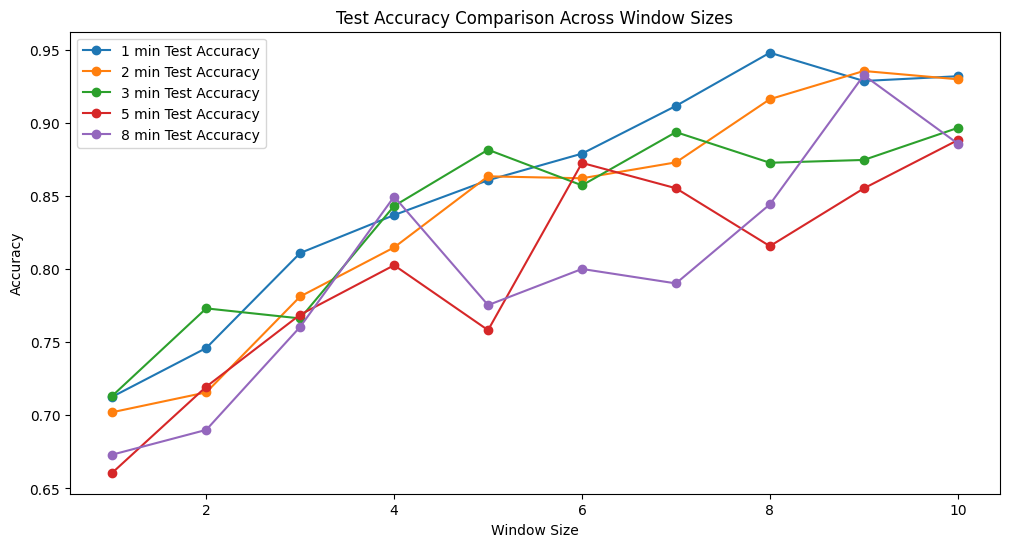

In [12]:
# get results
results_df = pd.DataFrame(window_size_results)
print(results_df)

# plot accuracy comparison by window size
plt.figure(figsize=(12, 6))
for interval in ['1 min', '2 min', '3 min', '5 min', '8 min']:
    interval_results = results_df[results_df['interval'] == interval]
    plt.plot(interval_results['window_size'], interval_results['accuracy'], marker='o', label=f'{interval} Test Accuracy')
plt.title('Test Accuracy Comparison Across Window Sizes')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()